# CLASSIFICATION DE TEXTE

In [1]:
!pip install beautifulsoup4
!pip install kaggle
!pip install pandas nltk
!pip install tensorflow

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
Mots_a_retirer = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
racine = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
100% 25.7M/25.7M [00:00<00:00, 57.9MB/s]
100% 25.7M/25.7M [00:00<00:00, 51.6MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [4]:
Data = pd.read_csv('IMDB Dataset.csv')

In [5]:
Data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
# Fonction pour supprimer les balises HTML et les ponctuations
def clean_html(x):
    return BeautifulSoup(x, "html.parser").get_text()

def remove_punctuation(y):
    return y.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(z):
    words = word_tokenize(z)
    # return ' '.join([word for word in words.split(" ") if word.lower() not in Mots_a_retirer])
    return ' '.join([word for word in words if word.lower() not in Mots_a_retirer])



In [7]:
Data['review'] = Data['review'].apply(clean_html) #Suppression balise HTML
Data['review'] = Data['review'].apply(remove_punctuation)  #Suppression des ponctuations
Data['review']= Data['review'].str.lower()  #Caster tout en miniscule
Data['new_reviews'] = Data['review'].apply(remove_stopwords) # Retrait des stop words
Data['new_reviews'] = Data['new_reviews'].apply(lambda x: racine.lemmatize(x)) # Lemmatisation

Data['new_reviews_tok'] = Data['new_reviews'].apply(lambda x: word_tokenize(x)) # Tokenisation

<ipython-input-6-8523ad586400>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, "html.parser").get_text()


In [8]:
# Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Data['new_reviews_tok'])
sequences = tokenizer.texts_to_sequences(Data['new_reviews_tok'])

In [9]:
sequence_lengths = [len(seq) for seq in sequences]
moy_words = pd.Series(sequence_lengths)
moy_words.describe()

count    50000.000000
mean       119.842880
std         90.091683
min          3.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1429.000000
dtype: float64

In [10]:
moy_words

0        168
1         84
2         86
3         67
4        125
        ... 
49995     85
49996     55
49997    115
49998    115
49999     68
Length: 50000, dtype: int64

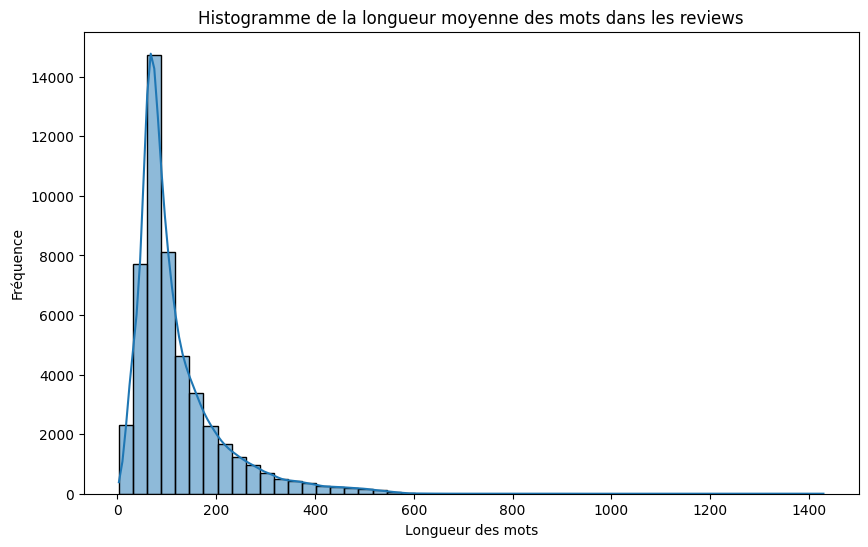

In [11]:
# Tracer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(moy_words, bins=50, kde=True)
plt.title('Histogramme de la longueur moyenne des mots dans les reviews')
plt.xlabel('Longueur des mots')
plt.ylabel('Fréquence')
plt.show()


In [12]:
max_length = 410
X = pad_sequences(sequences, maxlen=max_length)

In [13]:
word_counts = tokenizer.word_counts

word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['word', 'count'])
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

# Je ne garde que les mots qui reviennent plus de 10 fois
filtered_word_counts_df = word_counts_df[word_counts_df['count'] > 10]

Max_words = len(filtered_word_counts_df)
print(Max_words)

28120


In [14]:
le = LabelEncoder()
y = le.fit_transform(Data['sentiment'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Entraînement de modèle

### Early stopping

In [16]:
model = Sequential()
model.add(Dense(32, activation='relu'))


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Learning rate decay

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

In [19]:
model_lstm = Sequential([
    Embedding(input_dim=Max_words, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [20]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Entraînement du modèle
History = model_lstm.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split = 0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
500/500 [==============================] - 72s 128ms/step - loss: 0.3785 - accuracy: 0.8313 - val_loss: 0.2917 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 47s 93ms/step - loss: 0.1864 - accuracy: 0.9321 - val_loss: 0.3730 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 34s 68ms/step - loss: 0.1082 - accuracy: 0.9631 - val_loss: 0.3989 - val_accuracy: 0.8755 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 29s 58ms/step - loss: 0.0685 - accuracy: 0.9776 - val_loss: 0.5628 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 29s 59ms/step - loss: 0.0473 - accuracy: 0.9847 - val_loss: 0.5351 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 25s 51ms/step - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.4951 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 7/100
500/500 [==============================

In [22]:
model_lstm.save_weights('model_weights.h5')

# Test Modèles

Matrice de confusion

In [29]:
y_pred = model_lstm.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
# y_true = y_test
conf_mat = confusion_matrix(y_test, y_pred_classes)
tn, tp, fn, fp = conf_mat.ravel()

313/313 [==============================] - 4s 12ms/step


Métriques de performance

In [33]:
loss, accuracy_1 = model_lstm.evaluate(X_test, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.2785 - accuracy: 0.8852


In [34]:
accuracy = accuracy_score(y_test, y_pred_classes) #Accuracy
precision = precision_score(y_test, y_pred_classes) #Precision
recall = recall_score(y_test, y_pred_classes) #Recall
f1 = f1_score(y_test, y_pred_classes) #F1
sensibility = recall #Sensibilité
specificity = tn / (tn + fp) #Spécificité

In [36]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Sensibilité: {sensibility:.4f}')
print(f'Specificité: {specificity:.4f}')

Accuracy: 0.8852
Precision: 0.9227
Recall: 0.8428
F1 Score: 0.8809
Sensibilité: 0.8428
Specificité: 0.5202


Calcul de l’AUC et affichage de la courbe ROC

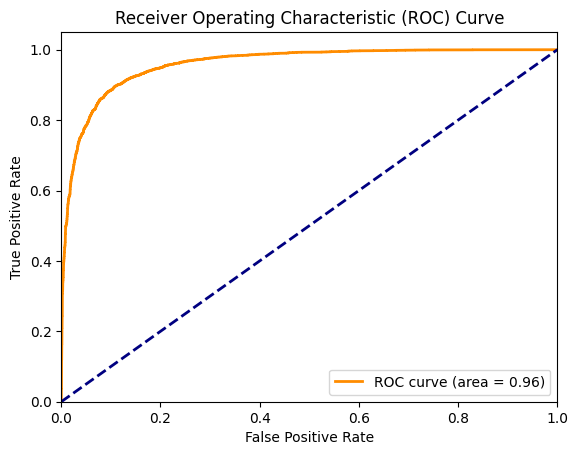

AUC: 0.9584


In [38]:
# Calcul de l'AUC et de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Affichage de l'AUC
print(f'AUC: {roc_auc:.4f}')

## Interprétation

La courbe ROC étant plus proche du coin supérieur gauche ajouté à l'AUC qui est égale à 0.96, cela nous indique que le modèle a bien performé.